In [1]:
import simplejson
import os
import numpy as np
import pandas as pd
import skimage.io
import skimage.filters.rank
import skimage.morphology
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Scene:
    def __init__(self, config_file_name):
        with open(config_file_name) as f:
            self.config = simplejson.load(f)

    def normalize_img(self, index, channel, norm_type='none', path='solp'):
        img_red = self.read_image(index, 'red', path)
        img_nir = self.read_image(index, 'nir', path)
        mask = self.read_image(index, 'mask', path)
        
        if False: ### DANGEROUS ###
            img_red = skimage.filters.rank.median(img_red, skimage.morphology.disk(15), mask=mask)
            img_nir = skimage.filters.rank.median(img_nir, skimage.morphology.disk(15), mask=mask)
            
        mean_red = img_red[mask == 255].mean()
        mean_nir = img_nir[mask == 255].mean()
        std_red = img_red[mask == 255].std()
        std_nir = img_nir[mask == 255].std()
        
        rad_refl = pd.read_csv(os.path.join(self.config['path'], self.config['paths']['docs'],
                                            self.config['docs']['rad_refl']))
        rad_red = rad_refl['rad_red'][index]
        rad_nir = rad_refl['rad_nir'][index]
        refl_red = rad_refl['refl_red'][index]
        refl_nir = rad_refl['refl_nir'][index]
        
        if channel == 'red':
            img, rad, refl, mean, std = img_red, rad_red, refl_red, mean_red, std_red
        elif channel == 'nir':
            img, rad, refl, mean, std = img_nir, rad_nir, refl_nir, mean_nir, std_nir
        else:
            img = self.read_image(index, channel, path)
            rad = rad_refl['rad_' + channel][index]
            refl = rad_refl['refl_' + channel][index]
            mean = img[mask == 255].mean()
            std = img[mask == 255].std()
        
        if norm_type == 'none':
            subtrahend = 0
            divider = 1
        elif norm_type == 'refl':
            subtrahend = rad
            divider = refl
        elif norm_type == 'disp':
            subtrahend = mean
            divider = std
        elif norm_type == 'reflshiftshrink12':
            if channel == 'red':
                subtrahend = mean_red
                divider = refl
            elif channel == 'nir':
                subtrahend = mean_nir
                divider = refl * np.tan(np.radians(45 + 12))
        elif norm_type == 'reflshiftE':
            e1 = refl_red
            e2 = refl_nir * np.tan(np.radians(45 + 12))
            k1 = mean_red - rad_red
            k2 = mean_nir - rad_nir
            if channel == 'red':
                subtrahend = rad_red + (k1 / e1 - k2 / e2) / 2 * e1
                divider = refl_red
            elif channel == 'nir':
                subtrahend = rad_nir - (k1 / e1 - k2 / e2) / 2 * e2
                divider = refl_nir * np.tan(np.radians(45 + 12))
        
        return (img.astype(np.float) - subtrahend) / divider

    def read_image(self, index, channel, path):
        return skimage.io.imread(os.path.join(self.config['path'], self.config['paths'][path], channel,
                                              self.config['scenes'][index]['path'] + self.config['suffs'][path]))

    def calculate_soil_line(self, img_red, img_nir, mask=None):
        if mask is None:
            x = img_red.reshape((-1,))
            y = img_nir.reshape((-1,))
        else:
            x = img_red[mask == 255]
            y = img_nir[mask == 255]
        return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]
    
    def make_channel_time_array(self, channel, norm_type='none', path='solp'):
        n_imgs = len(self.config['scenes'])
        width = self.config['size']['width']
        height = self.config['size']['height']
        
        if channel == 'mask':
            dtype = np.uint8
        else:
            dtype = np.float
        
        arr = np.empty((height, width, n_imgs), dtype=dtype)
        for i in range(n_imgs):
            if channel == 'mask':
                arr[:, :, i] = self.read_image(i, channel, path)
            else:
                arr[:, :, i] = self.normalize_img(i, channel, norm_type, path)
        return arr
    
    def calculate_features(self, feature_types=['red_mean', 'nir_mean', 'soil_line_a', 
                                                'red_std', 'red_min', 'red_max', 
                                                'nir_std', 'nir_min', 'nir_max', 
                                                'n_nonzero'], 
                           norm_type='none', path='solp', n_nonzero_limit=6):     
        if True:
            reds = self.make_channel_time_array('red', norm_type, path)
            nirs = self.make_channel_time_array('nir', norm_type, path)
            masks = self.make_channel_time_array('mask', norm_type, path)
            reds[masks == 0] = np.nan
            nirs[masks == 0] = np.nan
            red_mean = np.nanmean(reds, axis=2)
            nir_mean = np.nanmean(nirs, axis=2)
        n_nonzero = np.count_nonzero(masks, axis=2)
        
        res = []
        for f in feature_types:
            if f == 'red_mean':
                res.append(red_mean)
            if f == 'nir_mean':
                res.append(nir_mean)
            if f == 'soil_line_a':
                red_var = np.nanvar(reds, axis=2)
                red_nir_mult = np.nanmean(reds * nirs, axis=2)
                res.append((red_nir_mult - red_mean * nir_mean) / red_var)
            if f == 'red_std':
                res.append(np.nanstd(reds, axis=2))
            if f == 'red_min':
                res.append(np.nanmin(reds, axis=2))
            if f == 'red_max':
                res.append(np.nanmax(reds, axis=2))   
            if f == 'nir_std':
                res.append(np.nanstd(nirs, axis=2))
            if f == 'nir_min':
                res.append(np.nanmin(nirs, axis=2))
            if f == 'nir_max':
                res.append(np.nanmax(nirs, axis=2))
            if f == 'nir_percentile80':
                res.append(np.nanpercentile(nirs, 80, axis=2))
            if f == 'nir_percentile20':
                res.append(np.nanpercentile(nirs, 20, axis=2)) 
            if f == 'red_percentile80':
                res.append(np.nanpercentile(reds, 80, axis=2))
            if f == 'red_percentile20':
                res.append(np.nanpercentile(reds, 20, axis=2)) 
            if f == 'n_nonzero':
                res.append(n_nonzero)
        res = np.transpose(np.array(res), [1, 2, 0])
        res[n_nonzero < n_nonzero_limit] = np.nan
        return res
    
    def train_test_all_split(self, X, y, train_size, test_size=0, train_mask=None):
        if train_mask is None:
            train_mask = np.ones(y.shape, dtype=np.bool)
        X_all = X.reshape((-1, X.shape[2]))
        y_all = y.reshape((-1,))

        Xy = np.concatenate([X, y.reshape(y.shape + (1,))], axis=2)
        Xy[Xy[:, :, -1] < 1] = np.nan

        for t in ['train', 'test']:
            if t == 'train':
                Xy_tmp = np.copy(Xy[train_mask > 0])
                size = train_size
            else:
                Xy_tmp = np.copy(Xy[train_mask <= 0])
                size = test_size
            if size <= 0:
                X_tmp, y_tmp = None, None
            else:
                Xy_tmp = Xy_tmp[~np.isnan(Xy_tmp).any(axis=1)]
                Xy_tmp = Xy_tmp[np.random.choice(Xy_tmp.shape[0], size, replace=False)]
                X_tmp = Xy_tmp[:, :-1]
                y_tmp = Xy_tmp[:, -1].astype(np.int)
            if t == 'train':
                X_train, y_train = np.copy(X_tmp), np.copy(y_tmp)
            else:
                X_test, y_test = np.copy(X_tmp), np.copy(y_tmp)
        del Xy_tmp, X_tmp, y_tmp
        return X_train, y_train, X_test, y_test, X_all, y_all
    
    def load_soil_cuts(self):
        return pd.read_csv(os.path.join(self.config['path'], self.config['paths']['docs'], 
                                        self.config['docs']['cuts']))[['col', 'row', 'nsoil2_k']].values
    
    def load_soil_map(self):
        return skimage.io.imread(os.path.join(self.config['path'], self.config['paths']['docs'], 
                                              self.config['docs']['soil_map']))
    
    def load_gran_map(self):
        return skimage.io.imread(os.path.join(self.config['path'], self.config['paths']['docs'], 
                                              self.config['docs']['gran_map']))
    
    def get_shape(self):
        return (self.config['size']['height'], self.config['size']['width'])

In [28]:
A = Scene('3.json')
features = A.calculate_features(norm_type='disp')
soil_map = A.load_soil_map()
X_train, y_train, X_test, y_test, X_all, y_all = A.train_test_all_split(features, soil_map, 100000)
del features


/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:110: RuntimeWarning: Mean of empty slice
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:111: RuntimeWarning: Mean of empty slice
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:121: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:122: RuntimeWarning: Mean of empty slice
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:127: RuntimeWarning: All-NaN axis encountered
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:129: RuntimeWarning: All-NaN slice encountered
/home/fila/.local/lib/python3.5/site-packages/i

In [29]:
print(X_train.shape, y_train.shape, 
      X_test.shape, y_test.shape,
      X_all.shape, y_all.shape)

(100000, 10) (100000,) (10000, 10) (10000,) (5873660, 10) (5873660,)


In [4]:
def xgboost_save_map(clf, X, shape, file_name):
    y_pred = clf.predict(xgboost.DMatrix(X)).astype(np.int)
    y_pred[np.isnan(X).any(axis=1)] = 0
    skimage.io.imsave(file_name + '.png', y_pred.reshape(shape))
    
def xgboost_save_class_maps(clf, X, shape, file_name):
    y_pred_cl = np.exp(clf.predict(xgboost.DMatrix(X), output_margin=True))
    y_pred_cl /= np.sum(y_pred_cl, axis=1, keepdims=True)
    for i in range(1, y_pred_cl.shape[1]):
        y_pred = (y_pred_cl[:, i] * 255).astype(np.uint8)
        y_pred[np.isnan(X).any(axis=1)] = 0
        skimage.io.imsave(file_name + '/tmp' + str(i) + '.png', y_pred.reshape(shape))

In [8]:
from sklearn.metrics import accuracy_score
import xgboost
import warnings
warnings.filterwarnings('ignore')

A = Scene('3.json')
features = A.calculate_features(norm_type='disp')
soil_map = A.load_soil_map()
shape = (A.config['size']['height'], A.config['size']['width'])

xgboost_params = {'objective': 'multi:softmax',
            # 'booster': 'dart',
            'eta': 0.1, 'gamma': 0.0,
            'num_class': 10, 'max_depth': 9, 'subsample': 1.0}

for i in range(6):
    name = 'tmp' + str(i)
    print(name)
    train_mask = np.zeros(soil_map.shape, dtype=np.bool)
    train_mask[i * 350:i * 350 + 700, :] = True
    if i == 5:
        train_mask[:350, :] = True
    skimage.io.imsave('tmp/' + name + '_mask.png', train_mask.astype(np.uint8) * 255)
    X_train, y_train, X_test, y_test, X_all, y_all = A.train_test_all_split(features, soil_map, 100000, 10000,
                                                                            train_mask=train_mask)
    clf = xgboost.train(xgboost_params, xgboost.DMatrix(X_train, label=y_train), 
                        verbose_eval=True, num_boost_round=15)
    print('test acc:', accuracy_score(y_test, clf.predict(xgboost.DMatrix(X_test)).astype(np.int)))
    print('train acc:', accuracy_score(y_train, clf.predict(xgboost.DMatrix(X_train)).astype(np.int)))
    xgboost_save_map(clf, X_all, shape, 'tmp/' + name)
    xgboost_save_class_maps(clf, X_all, shape, 'tmp/' + name + '/')

tmp0
test acc: 0.9101
train acc: 0.96963
tmp1
test acc: 0.9228
train acc: 0.9643
tmp2
test acc: 0.9168
train acc: 0.97022
tmp3
test acc: 0.8959
train acc: 0.9845
tmp4
test acc: 0.881
train acc: 0.98388
tmp5
test acc: 0.8968
train acc: 0.97787


In [9]:
X_train, y_train, X_test, y_test, X_all, y_all = A.train_test_all_split(features, soil_map, 100000)
clf = xgboost.train(xgboost_params, xgboost.DMatrix(X_train, label=y_train), 
                    verbose_eval=True, num_boost_round=15)
xgboost_save_map(clf, X_all, shape, 'tmp_5_100p')

In [50]:

1000 ---- 
2000 ---- 
5000 ---- 
10000 --- 
20000 --- 
30000 --- 
50000 --- 
100000 -- 0.24758 (200, 0.1), 0.18786 (600, 0.2)
1000000 - 0.18671 (200, 0.1), 0.049734 (1000, 0.2)

2

In [35]:
import xgboost

class Error_i:
    def __init__(self, i):
        self.i = i
        
    def __call__(self, y_pred, dtrain):
        y_train_i = dtrain.get_label() == self.i
        y_pred_i = y_pred[y_train_i]
        return 'error_{}'.format(i), len(y_pred_i[y_pred_i == self.i]) / np.count_nonzero(y_train_i)

xgboost_params = {'objective': 'multi:softmax',
            # 'booster': 'dart',
            'eta': 0.1, 'gamma': 0.0,
            'num_class': 10, 'max_depth': 9, 'subsample': 1.0}
if True:
    df = xgboost.cv(xgboost_params, xgboost.DMatrix(X_train, label=y_train), 
                    verbose_eval=True, stratified=True, metrics={'merror'},#  feval=Error_i(0),
                    nfold=5, num_boost_round=15)
else:
    clf = xgboost.train(xgboost_params, xgboost.DMatrix(X_train, label=y_train), 
                        verbose_eval=True, num_boost_round=15)
    xgboost.plot_importance(clf)

[0]	train-merror:0.253175+0.00218294	test-merror:0.27762+0.00431147
[1]	train-merror:0.237523+0.00228375	test-merror:0.26214+0.00405463
[2]	train-merror:0.231945+0.00133256	test-merror:0.25734+0.00389823
[3]	train-merror:0.225797+0.00115109	test-merror:0.25296+0.00369747
[4]	train-merror:0.220942+0.00167449	test-merror:0.249469+0.00475189
[5]	train-merror:0.216642+0.00136732	test-merror:0.24596+0.00400428
[6]	train-merror:0.213268+0.00151786	test-merror:0.24284+0.00422309
[7]	train-merror:0.210175+0.00115175	test-merror:0.24057+0.0036801
[8]	train-merror:0.206815+0.00123015	test-merror:0.23768+0.00369922
[9]	train-merror:0.204313+0.00129599	test-merror:0.23612+0.00363897
[10]	train-merror:0.20186+0.00109808	test-merror:0.23367+0.00319843
[11]	train-merror:0.198682+0.00131742	test-merror:0.23142+0.00282804
[12]	train-merror:0.19616+0.00146275	test-merror:0.22935+0.00265866
[13]	train-merror:0.19353+0.00154596	test-merror:0.22731+0.00245892
[14]	train-merror:0.191137+0.00177243	test-merr

In [37]:
# for test
y_pred = clf.predict(xgboost.DMatrix(X_test)).astype(np.int)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.51380000000000003

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: tmp3.png is a low contrast image
  warn('%s is a low contrast image' % fname)


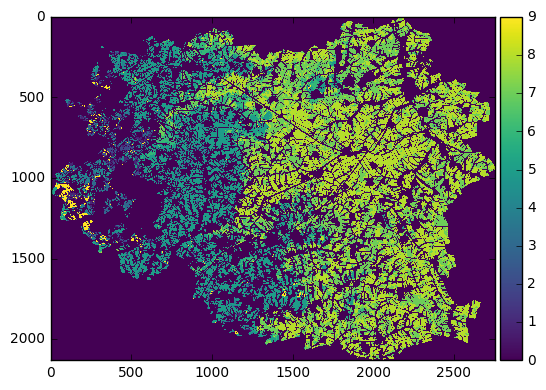

In [26]:
# for classes of all
y_pred = clf.predict(xgboost.DMatrix(X))
y_pred = y_pred.astype(np.int)
y_pred += 1
y_pred[np.isnan(X).any(axis=1)] = 0
skimage.io.imshow(y_pred.reshape((A.config['size']['height'], A.config['size']['width'])))
skimage.io.imsave('tmp3.png', y_pred.reshape((A.config['size']['height'], A.config['size']['width'])))

In [27]:
# for probas of all map
y_pred_cl = np.exp(clf.predict(xgboost.DMatrix(X), output_margin=True))
y_pred_cl /= np.sum(y_pred_cl, axis=1, keepdims=True)
path = 'tmp3/'
for i in range(y_pred_cl.shape[1]):
    y_pred = (y_pred_cl[:, i] * 255).astype(np.uint8)
    y_pred += 1
    y_pred[np.isnan(X).any(axis=1)] = 0
    skimage.io.imsave(path + str(i + 1) + '.png', 
                      y_pred.reshape((A.config['size']['height'], A.config['size']['width'])))

In [44]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from time import time

%matplotlib inline

def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if False: # hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X_trval)

Computing t-SNE embedding


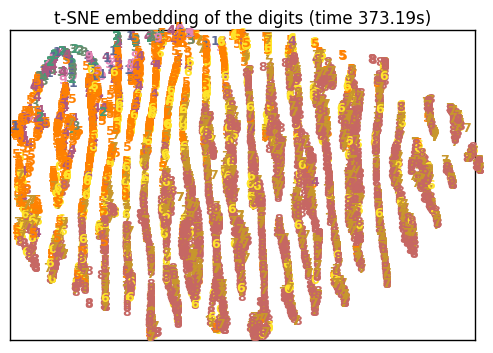

In [50]:
plot_embedding(X_tsne, y_trval, 
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

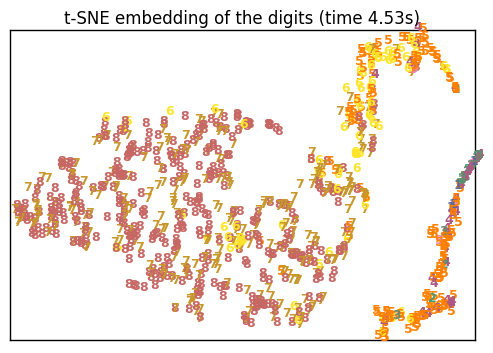

In [72]:
plot_embedding(X_tsne, y, 
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

In [76]:
import os
path = '/home/fila/Downloads/Tula_landsat_band_all/'
path_out = '/home/fila/Desktop/landsat2/original/'
filenames = os.listdir(path)

info = {
    'red': [3, 4],
    'nir': [4, 5],
    'blue': [1, 2],
    'green': [2, 3]
}

use_ch = ['red', 'nir', 'blue', 'green']

for ch in use_ch:
    print(ch)
    for f in filenames:
        if (f[2] != '8' and f.split('_')[1].lower() == 'b' + str(info[ch][0]))\
            or (f[2] == '8' and f.split('_')[1].lower() == 'b' + str(info[ch][1])):
            f_lower = f.split('_')[0].lower()
            print(f_lower)
            img = skimage.io.imread(path + f)
            skimage.io.imsave(path_out + ch + '/' + f_lower + '.tif', img[26:-23, 73:-54])

red
lt51780231989147kis00
lt51780231985216xxx03
lt51780231990134kis01
lt51780232010221kis01
lt51780232011240kis01
lt51780231994241kis00
le71780232002287sgs01
le71780232002239sgs01
lt51780232007229mor00
lt51780231986347xxx03


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/red/lt51780231986347xxx03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lc81780232015075lgn00
lc81780232014296lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/red/lc81780232014296lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lc81780232014264lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/red/lc81780232014264lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780232011208kis01
lc81780232015187lgn00
lt51780232006226kis02
le71780232003146asn00
lt51780231998092kis00
lt51780231987302kis00
le71780232000138sgs00
lt51780231994193kis00
le71780231999279edc00
lt51780232003266mti01
lt51780231986123xxx02
lt51780231986187xxx03
lc81780232014088lgn00
lt51780231988273kis00
le71780232002143sgs00
lc81780232014232lgn00
le71780232001124sgs01
lt51780231998140kis00


/usr/local/lib/python3.5/dist-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


lt51780231985136kis00
lt51780232011128kis00
lt51780231989195kis00
lt51780231986171xxx04
nir
lt51780231986347xxx03
lc81780232014264lgn00
lt51780231998140kis00
lt51780232003266mti01
lt51780232006226kis02
lt51780231994193kis00
lt51780231988273kis00
lt51780231998092kis00
lc81780232014296lgn00
lt51780231989195kis00
le71780232002143sgs00
le71780232001124sgs01
le71780232003146asn00
le71780231999279edc00
lc81780232015075lgn00
le71780232000138sgs00
lt51780232010221kis01
lt51780232011240kis01
lt51780231986123xxx02
le71780232002239sgs01
lc81780232014088lgn00
lt51780231989147kis00
le71780232002287sgs01
lc81780232014232lgn00
lc81780232015187lgn00
lt51780231990134kis01
lt51780231994241kis00
lt51780231985136kis00
lt51780231986171xxx04
lt51780231986187xxx03
lt51780231985216xxx03
lt51780232011208kis01
lt51780232007229mor00
lt51780231987302kis00
lt51780232011128kis00
blue
lt51780231994241kis00
lt51780231988273kis00
le71780231999279edc00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/blue/le71780231999279edc00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780232011208kis01
le71780232001124sgs01
lc81780232014264lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/blue/lc81780232014264lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780231989147kis00
lc81780232014296lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/blue/lc81780232014296lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780231985216xxx03
lt51780231998092kis00
lt51780231987302kis00
lc81780232014088lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/blue/lc81780232014088lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780232011128kis00
lt51780232006226kis02
lt51780231985136kis00
le71780232002287sgs01


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/blue/le71780232002287sgs01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780232003266mti01
le71780232003146asn00
lt51780231990134kis01
lc81780232015187lgn00
lt51780231986123xxx02
lt51780232010221kis01
lt51780231989195kis00
lt51780231994193kis00
lt51780231986171xxx04
le71780232000138sgs00
lc81780232014232lgn00
lt51780231986187xxx03
lt51780232007229mor00
lt51780231998140kis00
lc81780232015075lgn00
lt51780231986347xxx03


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/blue/lt51780231986347xxx03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780232011240kis01
le71780232002143sgs00
le71780232002239sgs01
green
lc81780232014088lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/green/lc81780232014088lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


le71780232003146asn00
le71780232002239sgs01
le71780232002287sgs01
lt51780232010221kis01
lt51780231988273kis00
lc81780232015187lgn00
lt51780232003266mti01


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/green/lt51780232003266mti01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780232006226kis02
lt51780232011208kis01
lt51780231998092kis00
lt51780232007229mor00
lt51780231994241kis00
lc81780232014296lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/green/lc81780232014296lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lc81780232014232lgn00
le71780232000138sgs00
le71780232002143sgs00
lt51780232011128kis00
lt51780231986123xxx02
lc81780232014264lgn00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/green/lc81780232014264lgn00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780231989147kis00
lc81780232015075lgn00
lt51780231998140kis00
le71780231999279edc00
lt51780231986187xxx03
le71780232001124sgs01
lt51780231986171xxx04
lt51780231986347xxx03


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/green/lt51780231986347xxx03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780231985136kis00
lt51780231990134kis01
lt51780231987302kis00


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: /home/fila/Desktop/landsat2/original/green/lt51780231987302kis00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


lt51780231985216xxx03
lt51780231994193kis00
lt51780231989195kis00
lt51780232011240kis01


In [47]:
img = np.random.randint(2, size=(5, 5))
img

array([[0, 0, 0, 1, 1],
       [1, 1, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0]])

In [48]:
mask = np.zeros((5, 5), dtype=np.int)
mask[:3, :] = 1
mask

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [51]:
from skimage.filters.rank import median
from skimage.morphology import disk, square

median(img, disk(1), mask=mask)

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  warn(msg)


array([[0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [26]:
img = skimage.io.imread('/home/fila/Desktop/landsat2/original/red/lc81780232014088lgn00.tif')
mask = skimage.io.imread('/home/fila/Desktop/landsat2/original/mask/lc81780232014088lgn00.tif')

In [9]:
img1 = skimage.io.imread('/home/fila/Desktop/landsat2/docs/soil_map.tif')
img2 = skimage.io.imread('/home/fila/Desktop/landsat2/docs/soil_map_2.tif')
accuracy_score(img1.ravel(), img2.ravel())

0.65834590357630507

In [10]:
np.count_nonzero(img1)

2503407

In [11]:
np.count_nonzero(img2)

2159940

In [18]:
np.where(np.logical_and(img1 != img2, img1 != 0))[0].shape

(1610341,)

In [19]:
893066 / (1610341 + 893066)

0.356740234408548

In [ ]:
893066